In [1]:
import numpy as np
import copy
from time import time
# from numba import njit, prange
import matplotlib.pyplot as plt
from matplotlib import text
%matplotlib inline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition, mark_inset

In [2]:
def errbar(data):
    nsamp = 10
    nevery = int(data.shape[0] / nsamp)
    data_ = np.zeros(nsamp)
    for k in range(nsamp):
        data_[k] = data[k*nevery:(k+1)*nevery].mean()
    errbar_ = np.sqrt(data_.var()/(nsamp-1))
    return errbar_

In [361]:
colors = ["red", "blue"]

In [304]:
log_md = np.loadtxt("./log", skiprows=45, max_rows=10001)

### MD trajectory

In [305]:
xtraj_md = []
Ntraj_md = 10001
with open("lj.xyz", "r") as f:
    for i in range(Ntraj_md):
        for j in range(9):
            f.readline()
        for j in range(200):
            xtraj_md.append(f.readline().split()[2:])
    xtraj_md = np.array(xtraj_md, dtype="float").reshape(Ntraj_md, 200, 3)

### Density

In [368]:
prd[0]

5.893944052621499

In [367]:
200/(prd[0]*prd[1]*prd[2])

0.9768142093212165

## Define the LJ pair potential

In [4]:
rc = 2.5

In [5]:
def lj(r):
    return 4*(1/r**12 - 1/r**6)

In [6]:
ljrc = lj(rc)

In [7]:
def lj_shift(r):
    return lj(r) - ljrc

In [410]:
Rs = np.arange(0.95, 3.51, 0.01)
Us = lj_shift(Rs)
Us[Rs>rc] = 0

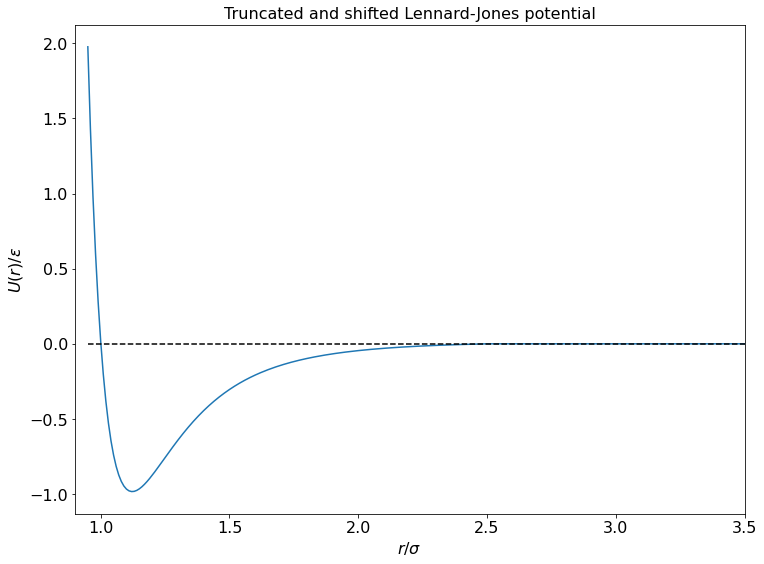

In [421]:
plt.figure(figsize=(12, 9))

plt.title("Truncated and shifted Lennard-Jones potential", fontsize=16)

plt.xlabel("$r / \\sigma$", fontsize=16)
plt.ylabel("$U(r) / \\epsilon$", fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(Rs[0]-0.05, Rs[-1])

plt.plot(Rs, Us)
plt.plot(Rs, 0*np.ones(Rs.shape[0]), color="black", linestyle="--")

## Read the initial configuration

In [8]:
Natom = 0
lo = []
hi = []
x0 = []
with open("init.xyz", "r") as f:
    for i in range(3):
        f.readline()
    Natom = int(f.readline().split()[0])
    f.readline()
    for i in range(3):
        line = f.readline().split()
        lo.append(float(line[0]))
        hi.append(float(line[1]))
    f.readline()
    for i in range(Natom):
        x0.append(f.readline().split()[2:])
lo = np.array(lo)
hi = np.array(hi)
prd = hi - lo
x0 = np.array(x0, dtype = float)

## Distance under the periodic boundary condition

In [9]:
def apply_pbc(x, prd, lo):
    s = x / prd
    return (s - np.floor(s))*prd+lo

In [10]:
def pbc_dist(dist, prd):
    s = dist / prd
    return (s - np.floor(s+0.5))*prd

## Potential energy calculation

In [11]:
def epair_atom(x, i):
    xi = x[i]
    ei = 0.0
    xjs = np.delete(x, i, axis=0)
    dxs = pbc_dist(xjs-xi, prd)
    rijs = np.sqrt((dxs**2).sum(axis=1))
    rijs_cut = rijs[rijs <= rc]
    eis = lj_shift(rijs_cut)
    ei = eis.sum()

    return ei

In [12]:
def epair(x):
    en = 0.0
    for i in range(Natom):
        en += epair_atom(x, i)
    return en / 2

In [13]:
elist0 = np.zeros(Natom)
for i in range(Natom):
    elist0[i] = epair_atom(x0, i)

In [14]:
pot0 = epair(x0)

## Monte Carlo move

In [177]:
delx = 0.2
Temp = 0.45
beta = 1. / Temp

In [178]:
def mcmove(x, rd1, rd2):
    t_epair_atom = 0
    t_metropolis = 0
    t_gennewconf = 0
    
    tflag0 = time()
    accept = 0
    idx = int(rd1*Natom)
    eno = epair_atom(x, idx)
    # generate the new configuration
    xi_new = x[idx] + 2*(np.random.rand(3)-0.5)*delx
    xi_new = apply_pbc(xi_new-lo, prd, lo)
    x_new = copy.deepcopy(x)
    x_new[idx] = xi_new    
    tflag1 = time()
    t_gennewconf += tflag1 - tflag0
    
    # calculate the potential energy of atom idx with the new configuration
    tflag0 = time()
    enn = epair_atom(x_new, idx)
    tflag1 = time()
    t_epair_atom += tflag1 - tflag0
    
    # determine whether to accept the move using Metropolis rule
    tflag0 = time()
    delen = enn - eno
    arg = np.exp(-beta * delen)
    if rd2 < arg:
        accept = 1
        x = x_new
        eiout = enn
    else:
        delen = 0.0
        eiout = eno
    tflag1 = time()
    t_metropolis += tflag1 - tflag0
    return x, idx, delen, accept, t_epair_atom, t_metropolis, t_gennewconf

In [326]:
Nstep = 10000000
Rands1 = np.random.rand(Nstep)
Rands2 = np.random.rand(Nstep)
Nwrite = 1000
Nsamp = int(Nstep/Nwrite)+1
Ntime = Nstep / 100
Naccept = 0
t_epair_atom = 0
t_metropolis = 0
t_gennewconf = 0
t_loop = 0
t_nonloop = 0

xtraj = np.zeros([Nsamp, Natom, 3])
pottraj = np.zeros(Nsamp)
xtraj[0] = copy.deepcopy(x0)
pottraj[0] = copy.deepcopy(pot0)

x = copy.deepcopy(x0)

pot = copy.deepcopy(pot0)

tstart = time()
t2 = tstart
for istep in range(Nstep):
    tflag0 = time()
    x, idx, delen, accept, tmc_epair_atom, tmc_metropolis, tmc_gennewconf = mcmove(x, Rands1[istep], Rands2[istep])
    tflag1 = time()
    t_loop += tflag1 - tflag0
    t_epair_atom += tmc_epair_atom
#     t_build_vlist += tmc_build_vlist
    t_metropolis += tmc_metropolis
    t_gennewconf += tmc_gennewconf
#     t_deepcopy += tmc_deepcopy
    
    tflag0 = time()
    pot += delen
    Naccept += accept
#     Nbuild += build
    if (istep+1) % Nwrite == 0:
        isamp = int((istep+1)/Nwrite)
        xtraj[isamp] = copy.deepcopy(x)
        pottraj[isamp] = copy.deepcopy(pot)
    if (istep+1) % Ntime == 0:
        t1 = time()
        print("%3d%% completed: %7d to %7d moves cost %.4f s."%((istep+1)/Nstep*100, istep+2-Ntime, istep+1, t1-t2))
        t2 = t1
    tflag1 = time()
    t_nonloop += tflag1 - tflag0
tend = time()
print("%d MC moves cost %.4f s."%(Nstep, tend-tstart))

print("\nAlgorithm Statistics:")
print("acceptance:            | {:.4%}".format(Naccept/Nstep))
# print("rebuild Vetlet list:   | {:.4%}".format(Nbuild/Nstep))

print("\nTime Statistics:")
print("epair_atom:        | {:2.4e} s. ----> {:.4%}".format(t_epair_atom, t_epair_atom/(tend-tstart)))
# print("build_vlist:       | {:2.4e} s. ----> {:.4%}".format(t_build_vlist, t_build_vlist/(tend-tstart)))
print("Metropolis:        | {:2.4e} s. ----> {:.4%}".format(t_metropolis, t_metropolis/(tend-tstart)))
print("generate new conf: | {:2.4e} s. ----> {:.4%}".format(t_gennewconf, t_gennewconf/(tend-tstart)))
# print("deepcopy:          | {:2.4e} s. ----> {:.4%}".format(t_deepcopy, t_deepcopy/(tend-tstart)))
print("MC loop:           | {:2.4e} s. ----> {:.4%}".format(t_loop, t_loop/(tend-tstart)))
print("non-MC loop:       | {:2.4e} s. ----> {:.4%}".format(t_nonloop, t_nonloop/(tend-tstart)))

  1% completed:       1 to  100000 moves cost 10.8175 s.
  2% completed:  100001 to  200000 moves cost 11.2489 s.
  3% completed:  200001 to  300000 moves cost 11.0453 s.
  4% completed:  300001 to  400000 moves cost 11.0307 s.
  5% completed:  400001 to  500000 moves cost 11.0275 s.
  6% completed:  500001 to  600000 moves cost 11.3919 s.
  7% completed:  600001 to  700000 moves cost 10.9876 s.
  8% completed:  700001 to  800000 moves cost 11.1557 s.
  9% completed:  800001 to  900000 moves cost 11.1567 s.
 10% completed:  900001 to 1000000 moves cost 11.2863 s.
 11% completed: 1000001 to 1100000 moves cost 10.8663 s.
 12% completed: 1100001 to 1200000 moves cost 11.0203 s.
 13% completed: 1200001 to 1300000 moves cost 10.5004 s.
 14% completed: 1300001 to 1400000 moves cost 10.1811 s.
 15% completed: 1400001 to 1500000 moves cost 10.6998 s.
 16% completed: 1500001 to 1600000 moves cost 10.6223 s.
 17% completed: 1600001 to 1700000 moves cost 11.0140 s.
 18% completed: 1700001 to 1800

In [327]:
np.save("xtraj.npy", xtraj)
np.save("pottraj.npy", pottraj)

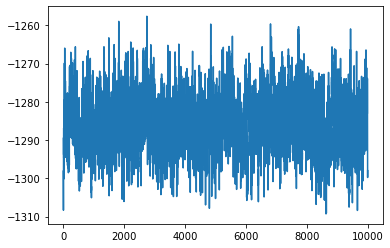

In [328]:
plt.plot(pottraj)

In [329]:
print("%.6f"%(Naccept / Nstep))

0.057059


## Potential energy distribution

In [348]:
potmean_mc = (pottraj/Natom).mean()
poterr_mc = errbar(pottraj/Natom)

In [349]:
potmean_md = (log_md[:, 3]/Natom).mean()
poterr_md = errbar(log_md[:, 2]/Natom)

In [351]:
print(potmean_mc)

-6.42936570409648


In [352]:
print(poterr_mc)

0.0020037696615327716


In [353]:
print(potmean_md)

-6.427518232006799


In [354]:
print(poterr_md)

0.0007235459184901278


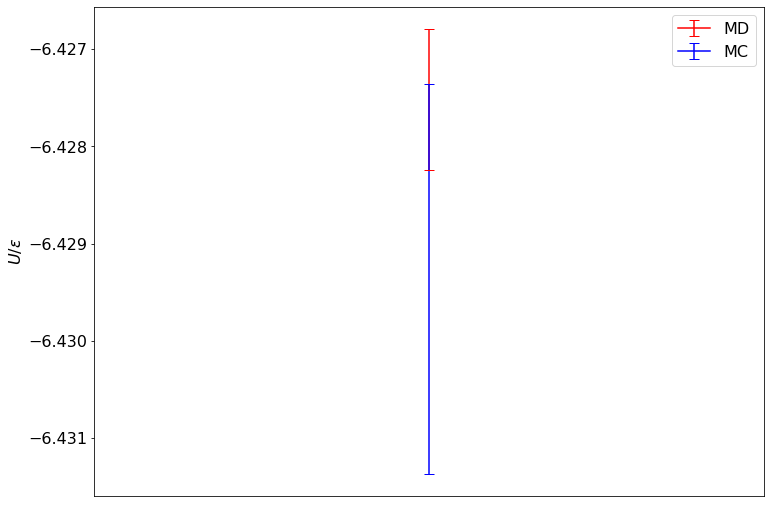

In [364]:
plt.figure(figsize=(12, 9))

plt.ylabel("$U / \\epsilon$", fontsize=16)
# plt.ylabel("$\\rho(U)$", fontsize=16)

plt.xticks([], fontsize=16)
plt.yticks(fontsize=16)

plt.errorbar(x=0, y = potmean_md, yerr = poterr_md, color = colors[0], capsize = 5.0, label="MD")
plt.errorbar(x=0, y = potmean_mc, yerr = poterr_mc, color = colors[1], capsize = 5.0, label="MC")

plt.legend(fontsize=16)

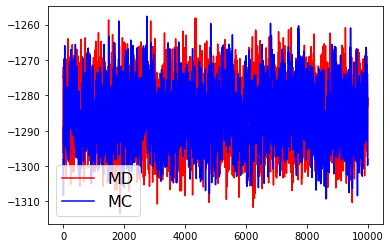

In [363]:
plt.plot(log_md[:, 3], color = colors[0], label="MD")
plt.plot(pottraj, color = colors[1], label="MC")
plt.legend(fontsize=16)

In [333]:
def pot_dist(pot_samp, nbin_pot, nsub):
    pot_array = np.zeros([nsub, nbin_pot])
    pot_dist = np.zeros([nsub, nbin_pot])
    
    potmin = np.min(pot_samp)
    potmax = np.max(pot_samp)
    
    nsamp = pot_samp.shape[0]
#     print(nsamp)
    nbatch = int(nsamp / nsub)
    pot_samps = pot_samp[nsamp-nbatch*nsub:]
#     print(pot_samps.shape)
    for isub in range(nsub):
        potdist = np.histogram(pot_samp[isub*nbatch:(isub+1)*nbatch], bins=nbin_pot, range = (potmin, potmax), density=True)

        pot_array[isub] = potdist[1][:-1] + 0.5 * (potdist[1][1] - potdist[1][0])
        pot_dist[isub] = potdist[0]
    return pot_array, pot_dist

In [340]:
nbin_pot = 100
nsub = 10
pot_array_mc, pot_dist_mc = pot_dist(pottraj/Natom, nbin_pot, nsub)
pot_mc_array = pot_array_mc[0]
pot_mc_mean, pot_mc_err = rdf_mean_err(pot_dist_mc) 
pot_array_md, pot_dist_md = pot_dist(log_md[:, 3]/Natom, nbin_pot, nsub)
pot_md_array = pot_array_md[0]
pot_md_mean, pot_md_err = rdf_mean_err(pot_dist_md) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


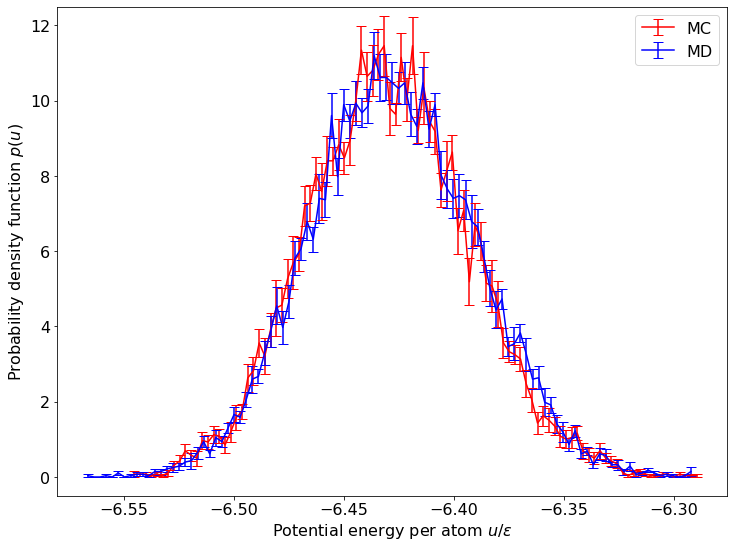

In [372]:
plt.figure(figsize=(12, 9))

plt.xlabel("Potential energy per atom $u / \\epsilon$", fontsize=16)
plt.ylabel("Probability density function $p(u)$", fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# plt.xlim()
plt.ylim(-0.5, 12.5)

plt.errorbar(x = pot_mc_array, y = pot_mc_mean, yerr = pot_mc_err, color = colors[0], capsize = 5, label = "MC")
plt.errorbar(x = pot_md_array, y = pot_md_mean, yerr = pot_md_err, color = colors[1], capsize = 5, label = "MD")
plt.legend(fontsize=16)

plt.savefig("rhoU.eps", format="eps")

## Radial distribution function

In [311]:
 def compute_rdf(xtraj):
    Nsamp_traj = xtraj.shape[0]
    Vol = prd[0]*prd[1]*prd[2]
    nbin = 200
    nsub=int(Nsamp_traj/10)
    dr=rc/nbin
    r_array = np.linspace(0, rc, num=nbin, endpoint=False)+0.5*dr
    r_array_10 = np.array([r_array for i in range(10)]).reshape(10, nbin)
    dists_array = np.zeros([Nsamp_traj, int(Natom*(Natom-1)/2)])
    g_r_array = np.zeros([Nsamp_traj, nbin])
    nbatch = 100
    nloop = int(Nsamp_traj/nbatch)

    for iloop in range(nloop):
        x_batch = xtraj[iloop*nbatch:(iloop+1)*nbatch]
        dist_batch = x_batch[:, None, :] - x_batch[:, :, None]
        dist_pbc=(dist_batch/prd-np.floor(dist_batch/prd+0.5))*prd
        dist_r=np.sqrt((dist_pbc**2).sum(axis=3))
        for ibatch in range(nbatch):
            isamp = iloop*nbatch + ibatch
    #         print(isamp)
            dists_array[isamp] = dist_r[ibatch][np.triu_indices(Natom, 1)]
            hist_r = np.histogram(dists_array[isamp], bins=nbin, range=(0, rc), density=False)
            g_r_array[isamp] = 2*hist_r[0]/4/np.pi/r_array**2/dr/Natom/(Natom-1)*Vol
    g_r_10 = np.zeros([10, nbin])
    for isub in range(10):
        g_r_10[isub] = g_r_array[isub*nsub:(isub+1)*nsub].mean(axis=0)
    return r_array_10, g_r_10

In [151]:
def rdf_mean_err(goo):
    return goo.mean(axis=0), np.sqrt(goo.var(axis=0))/3

In [312]:
r_md, g_array_md = compute_rdf(xtraj_md)
r_md_array = r_md[0]
g_md_mean, g_md_err = rdf_mean_err(g_array_md) 

In [197]:
r_mc, g_array_mc = compute_rdf(xtraj)
r_mc_array = r_mc[0]
g_mc_mean, g_mc_err = rdf_mean_err(g_array_mc) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


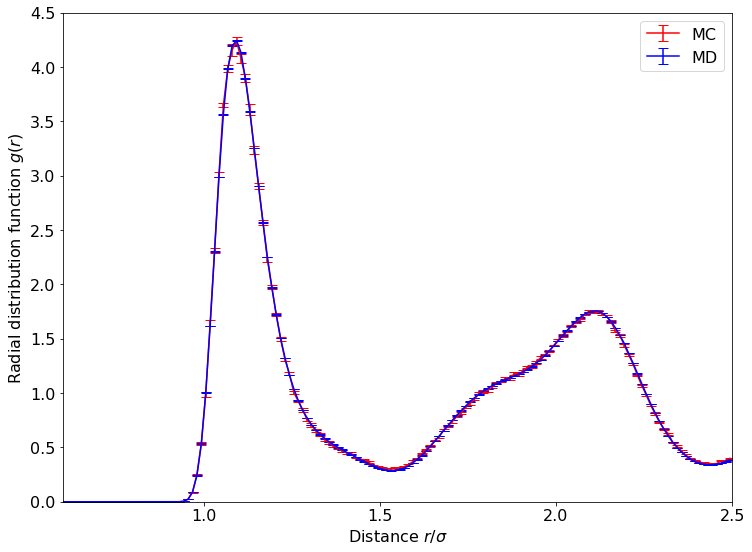

In [376]:
plt.figure(figsize=(12, 9))

plt.xlabel("Distance $r / \\sigma$", fontsize=16)
plt.ylabel("Radial distribution function $g(r)$", fontsize=16)

plt.xticks(np.arange(0, 2.51, 0.5), fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(0.6, 2.5)
plt.ylim(0.0, 4.5)

plt.errorbar(r_mc_array, y=g_mc_mean, yerr=g_mc_err, color = colors[0], capsize = 5.0, label="MC")
plt.errorbar(r_md_array, y=g_md_mean, yerr=g_md_err, color = colors[1], capsize = 5.0, label="MD")
plt.legend(fontsize=16)

plt.savefig("gofr.eps", format="eps")